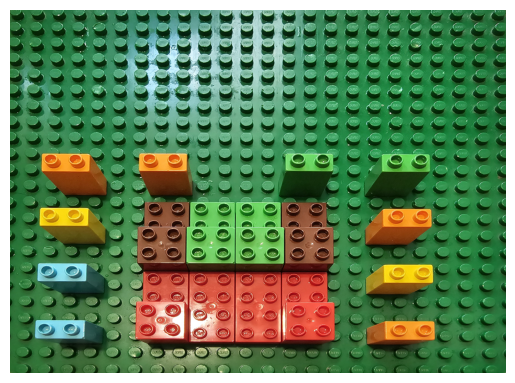

In [41]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the image
image_path = '/content/20240719_132425.jpg'
image = cv2.imread(image_path)
original = image.copy()

# Convert image to RGB (OpenCV uses BGR by default)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert to HSV for color detection
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the range for green color in HSV
lower_green = np.array([35, 40, 40])
upper_green = np.array([85, 255, 255])

# Threshold the HSV image to get only green colors
mask = cv2.inRange(hsv_image, lower_green, upper_green)

# Find contours
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours by area and get the largest one
contours = sorted(contours, key=cv2.contourArea, reverse=True)
largest_contour = contours[0]

# Approximate the contour to a rectangle
epsilon = 0.02 * cv2.arcLength(largest_contour, True)
approx = cv2.approxPolyDP(largest_contour, epsilon, True)

# Check if we have a 4-corner approximation
if len(approx) == 4:
    # Get the rectangle corners
    pts = approx.reshape(4, 2)

    # Order points to get consistent order: top-left, top-right, bottom-right, bottom-left
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # Compute width and height of the new image
    (tl, tr, br, bl) = rect
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)

    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))

    # Destination points for bird's eye view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    # Compute the perspective transform matrix and warp the perspective
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(original, M, (maxWidth, maxHeight))

    # # Plot the results
    # plt.figure(figsize=(10, 5))
    # plt.subplot(1, 2, 1)
    # plt.title('Original Image')
    # plt.imshow(image_rgb)
    # plt.axis('off')

    # plt.subplot(1, 2, 2)
    # plt.title('Cropped and Warped Image')
    plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()

else:
    print("Could not find a proper rectangle for the green area.")
